In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFTGate as QFT, DiagonalGate as Diagonal
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, depolarizing_error, 
                              thermal_relaxation_error, pauli_error)
import qiskit.quantum_info as qi

In [ ]:
def get_system_operators(n_qubits, L, mass, V0, width, separation):
    N = 2**n_qubits
    dx = L / N
    x = np.linspace(-L/2, L/2, N, endpoint=False)
    

    V_x = np.zeros(N)
    mask1 = (x > -separation/2 - width) & (x < -separation/2)
    mask2 = (x > separation/2) & (x < separation/2 + width)
    V_x[mask1 | mask2] = V0
    
    
    k_indices = np.arange(N)
    dk = 2 * np.pi / L
    # Standard FFT ordering logic for k values
    k_values = np.where(k_indices < N/2, k_indices * dk, (k_indices - N) * dk)
    T_k = (k_values**2) / (2 * mass)
    
    return x, V_x, T_k

def get_initial_wavepacket(n_qubits, x, x0, k0, sigma):
    psi = np.exp(-(x - x0)**2 / (2*sigma**2)) * np.exp(1j * k0 * x)
    psi = psi / np.linalg.norm(psi)
    return psi

class NoiseFactory:
    @staticmethod
    def get_noiseless():
        return NoiseModel()

    @staticmethod
    def get_depolarizing(prob=0.001):
 
        noise_model = NoiseModel()
        error_1 = depolarizing_error(prob, 1)
        error_2 = depolarizing_error(prob * 10, 2) # CNOTs are noisier
        noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'rz', 'x', 'h'])
        noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
        return noise_model
    
    @staticmethod
    def get_thermal(t1=90e3, t2=80e3, gate_time=50):
        noise_model = NoiseModel()
        
     
        error = thermal_relaxation_error(t1, t2, gate_time)
        
   
        noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3', 'rz', 'sx', 'x'])
        return noise_model

def run_strang_simulation(n_qubits, t_final, steps, noise_model):
   
    L, mass = 40.0, 0.5
    V0, width, sep = 4.0, 1.0, 2.5
    
 
    x, V_x, T_k = get_system_operators(n_qubits, L, mass, V0, width, sep)
    psi_0 = get_initial_wavepacket(n_qubits, x, x0=-10.0, k0=3.0, sigma=1.5)
    
    dt = t_final / steps
    

    op_V_half = Diagonal(np.exp(-1j * V_x * (dt / 2)))
    op_T_full = Diagonal(np.exp(-1j * T_k * dt))
    sim = AerSimulator(method='density_matrix', noise_model=noise_model)
    
    qc = QuantumCircuit(n_qubits)
    qc.initialize(psi_0, range(n_qubits))
    
    results = []
    

    qc_temp = qc.copy()
    qc_temp.save_density_matrix()
    rho = sim.run(transpile(qc_temp, sim)).result().data()['density_matrix']
    results.append(np.real(np.diag(rho)))
    
    print(f"Running simulation with NoiseModel: {bool(noise_model.to_dict())}")
    
    for _ in range(steps):
  
        qc.append(op_V_half, range(n_qubits))
        qc.append(QFT(n_qubits), range(n_qubits))
        qc.append(op_T_full, range(n_qubits))
        qc.append(QFT(n_qubits).inverse(), range(n_qubits))
        qc.append(op_V_half, range(n_qubits))
        
        qc_save = qc.copy()
        qc_save.save_density_matrix()
   
        job = sim.run(transpile(qc_save, sim))
        rho_data = job.result().data()['density_matrix']
        
        results.append(np.real(np.diag(rho_data)))
        
    return x, V_x, results

1. Simulating Ideal Case...
Running simulation with NoiseModel: True
2. Simulating Noisy Case...Depolarizing
Running simulation with NoiseModel: True
3. Simulating Noisy Case...Decoherence
Running simulation with NoiseModel: True
Saving animation to 'trotter_strang_noise.gif'...
Saved successfully! Check your folder.


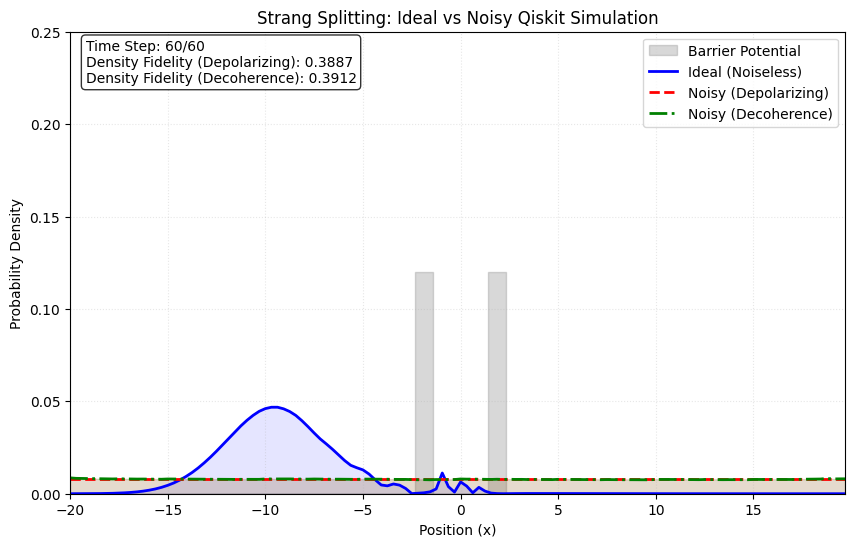

In [ ]:
n_qubits = 7         
t_end = 5.0          
n_steps = 60         

print("1. Simulating Ideal Case...")
x_grid, V_grid, probs_ideal = run_strang_simulation(
    n_qubits, t_end, n_steps, NoiseFactory.get_noiseless()
)

print("2. Simulating Noisy Case...Depolarizing")
# prob=0.0005 is approx 0.05% error per gate
x_grid, _, probs_noisy = run_strang_simulation(
    n_qubits, t_end, n_steps, NoiseFactory.get_depolarizing(prob=0.0005)
)

print("3. Simulating Noisy Case...Decoherence")
# prob=0.0005 is approx 0.05% error per gate
x_grid, _, probs_noisy2 = run_strang_simulation(
    n_qubits, t_end, n_steps, NoiseFactory.get_thermal(t1=90e3, t2=80e3, gate_time=50)
)

# --- Setup Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Strang Splitting: Ideal vs Noisy Qiskit Simulation")
ax.set_xlabel("Position (x)")
ax.set_ylabel("Probability Density")
ax.set_xlim(x_grid[0], x_grid[-1])
ax.set_ylim(0, 0.25) # Fix Y-limit so animation doesn't jump

# 1. Plot Potential (Background)
# Scale potential to fit nicely on probability graph
V_scale = 0.12 / np.max(V_grid)
ax.fill_between(x_grid, 0, V_grid * V_scale, step='mid', color='gray', alpha=0.3, label="Barrier Potential")

# 2. Initialize Lines
line_ideal, = ax.plot([], [], 'b-', lw=2, label="Ideal (Noiseless)")
line_noisy, = ax.plot([], [], 'r--', lw=2, label="Noisy (Depolarizing)")
line_noisy2, = ax.plot([], [], 'g-.', lw=2, label="Noisy (Decoherence)")

# Fills (initialized empty)
fill_ideal = ax.fill_between(x_grid, 0, 0, color='blue', alpha=0.1)
fill_noisy = ax.fill_between(x_grid, 0, 0, color='red', alpha=0.1)
fill_noisy2 = ax.fill_between(x_grid, 0, 0, color='green', alpha=0.1)

# Text Stats
stats_text = ax.text(0.02, 0.89, "", transform=ax.transAxes, 
                     bbox=dict(boxstyle="round", fc="white", alpha=0.8))

ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, linestyle=':')

def init():
    line_ideal.set_data([], [])
    line_noisy.set_data([], [])
    line_noisy2.set_data([], [])
    stats_text.set_text("")
    return line_ideal, line_noisy, stats_text, line_noisy2

def update(frame):
    # Data
    y_ideal = probs_ideal[frame]
    y_noisy = probs_noisy[frame]
    y_noisy2 = probs_noisy2[frame]
    
    # Force any tiny negative floats (e.g. -1e-18) to be exactly 0.0
    y_ideal = np.maximum(y_ideal, 0.0)
    y_noisy = np.maximum(y_noisy, 0.0)
    y_noisy2 = np.maximum(y_noisy2, 0.0)
    # ----------------------------------
    
    # Update Lines
    line_ideal.set_data(x_grid, y_ideal)
    line_noisy.set_data(x_grid, y_noisy)
    line_noisy2.set_data(x_grid, y_noisy2)
    
    # Update Fills
    verts_i = np.vstack([np.hstack([x_grid, x_grid[::-1]]), 
                         np.hstack([y_ideal, np.zeros_like(y_ideal)])]).T
    fill_ideal.set_paths([verts_i])
    
    verts_n = np.vstack([np.hstack([x_grid, x_grid[::-1]]), 
                         np.hstack([y_noisy, np.zeros_like(y_noisy)])]).T
    fill_noisy.set_paths([verts_n])

    verts_n2 = np.vstack([np.hstack([x_grid, x_grid[::-1]]), 
                         np.hstack([y_noisy2, np.zeros_like(y_noisy2)])]).T
    fill_noisy2.set_paths([verts_n2])
    
    overlap = np.sum(np.sqrt(y_ideal * y_noisy))**2
    overlap2 = np.sum(np.sqrt(y_ideal * y_noisy2))**2
    
    stats_text.set_text(f"Time Step: {frame}/{n_steps}\nDensity Fidelity (Depolarizing): {overlap:.4f}\nDensity Fidelity (Decoherence): {overlap2:.4f}")
    
    return line_ideal, line_noisy, fill_ideal, fill_noisy, fill_noisy2, stats_text

# Create Animation
ani = FuncAnimation(fig, update, frames=len(probs_ideal), 
                    init_func=init, blit=False, interval=100)

# Save it to ensure you see it!
print("Saving animation to 'trotter_strang_noise.gif'...")
try:
    ani.save("trotter_strang_noise.gif", writer=PillowWriter(fps=10))
    print("Saved successfully! Check your folder.")
except Exception as e:
    print(f"Could not save GIF: {e}")

plt.show()